# Machine Learning Assignment 2
## Murtaza Hussain (29449) and Muhammad Asad ur Rehman (29456)

In [129]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import classification_report, accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_classif, RFE, chi2, SequentialFeatureSelector, f_regression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from lazypredict.Supervised import LazyClassifier
from IPython.display import display

pd.options.display.float_format = '{:,.4f}'.format

In [130]:
# Data Loader loads data from UCI-ML Repo
def load_datasets():
    # Classification Datasets
    c_cancer = pd.read_csv("./Classification.CancerMB.csv").iloc[:, :32]
    c_mice_expression = pd.read_csv("./Classification.Mice.Expression.csv")#.iloc[:, :25]
    c_adult_income = pd.read_csv("./Classification.Adult.Income.csv")
    # Regression Datasets
    r_life_expectancy = pd.read_csv("./Regression.Life.Expectancy.csv")
    r_appartment_rent = pd.read_csv("./Regression.Appartment.Rent.csv")
    r_song_popularity = pd.read_csv("./Regression.Song.Popularity.csv")
    
    return c_cancer, c_mice_expression, c_adult_income, r_life_expectancy, r_appartment_rent, r_song_popularity

In [131]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64' and df[column].dtype != 'int64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())

        
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

In [132]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value = False):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

In [133]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64', 'int64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

In [134]:
def fwpMethodsClassification(df, target_name):
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    # Apply MinMax scaling to ensure non-negative values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize the classifiers
    lr_classifier = LogisticRegression()
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()

    # Initialize k-fold cross-validation where folds = 5
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Loop through different k values
    for k in [3, 5, 10]:
        # Apply chi-squared filter
        X_chi2 = SelectKBest(score_func=chi2, k=k).fit_transform(X_scaled, y)
        lr_chi2_scores = cross_val_score(lr_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
        rf_chi2_scores = cross_val_score(rf_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
        knn_chi2_scores = cross_val_score(knn_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
        lr_chi2_mean_accuracy = lr_chi2_scores.mean()
        rf_chi2_mean_accuracy = rf_chi2_scores.mean()
        knn_chi2_mean_accuracy = knn_chi2_scores.mean()

        # Apply forward selection wrapper
        lr_forward_selector = SequentialFeatureSelector(lr_classifier, n_features_to_select=k, direction='forward')
        X_forward = lr_forward_selector.fit_transform(X_scaled, y)
        lr_forward_scores = cross_val_score(lr_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
        rf_forward_scores = cross_val_score(rf_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
        knn_forward_scores = cross_val_score(knn_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
        lr_forward_mean_accuracy = lr_forward_scores.mean()
        rf_forward_mean_accuracy = rf_forward_scores.mean()
        knn_forward_mean_accuracy = knn_forward_scores.mean()

        # Apply backward selection wrapper
        lr_backward_selector = SequentialFeatureSelector(lr_classifier, n_features_to_select=k, direction='backward')
        X_backward = lr_backward_selector.fit_transform(X_scaled, y)
        lr_backward_scores = cross_val_score(lr_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
        rf_backward_scores = cross_val_score(rf_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
        knn_backward_scores = cross_val_score(knn_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
        lr_backward_mean_accuracy = lr_backward_scores.mean()
        rf_backward_mean_accuracy = rf_backward_scores.mean()
        knn_backward_mean_accuracy = knn_backward_scores.mean()

        # Apply PCA
        pca = PCA(n_components=k)
        X_pca = pca.fit_transform(X_scaled)
        lr_pca_scores = cross_val_score(lr_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
        rf_pca_scores = cross_val_score(rf_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
        knn_pca_scores = cross_val_score(knn_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
        lr_pca_mean_accuracy = lr_pca_scores.mean()
        rf_pca_mean_accuracy = rf_pca_scores.mean()
        knn_pca_mean_accuracy = knn_pca_scores.mean()

        results.append({
            'k': k,
            'LR with Chi2 Accuracy': lr_chi2_mean_accuracy,
            'RF with Chi2 Accuracy': rf_chi2_mean_accuracy,
            'KNN with Chi2 Accuracy': knn_chi2_mean_accuracy,
            'LR with Forward Selection Accuracy': lr_forward_mean_accuracy,
            'RF with Forward Selection Accuracy': rf_forward_mean_accuracy,
            'KNN with Forward Selection Accuracy': knn_forward_mean_accuracy,
            'LR with Backward Selection Accuracy': lr_backward_mean_accuracy,
            'RF with Backward Selection Accuracy': rf_backward_mean_accuracy,
            'KNN with Backward Selection Accuracy': knn_backward_mean_accuracy,
            'LR with PCA Accuracy': lr_pca_mean_accuracy,
            'RF with PCA Accuracy': rf_pca_mean_accuracy,
            'KNN with PCA Accuracy': knn_pca_mean_accuracy
        })

    df_results = pd.DataFrame(results)
    return df_results

In [135]:
def fwpMethodsRegression(df, target_name):
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    # Apply MinMax scaling to ensure non-negative values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize the regressors
    lr_regressor = LinearRegression()
    rf_regressor = RandomForestRegressor()
    knn_regressor = KNeighborsRegressor()

    # Initialize k-fold cross-validation where folds = 5
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Loop through different k values
    for k in [3, 5, 10]:
        # Apply ANOVA filter
        X_anova = SelectKBest(score_func=f_regression, k=k).fit_transform(X_scaled, y)
        lr_anova_scores = cross_val_score(lr_regressor, X_anova, y, cv=k_fold, scoring='neg_mean_squared_error')
        rf_anova_scores = cross_val_score(rf_regressor, X_anova, y, cv=k_fold, scoring='neg_mean_squared_error')
        knn_anova_scores = cross_val_score(knn_regressor, X_anova, y, cv=k_fold, scoring='neg_mean_squared_error')
        lr_anova_mean_mse = lr_anova_scores.mean()
        rf_anova_mean_mse = rf_anova_scores.mean()
        knn_anova_mean_mse = knn_anova_scores.mean()

        # Apply forward selection wrapper
        lr_forward_selector = SequentialFeatureSelector(lr_regressor, n_features_to_select=k, direction='forward')
        X_forward = lr_forward_selector.fit_transform(X_scaled, y)
        lr_forward_scores = cross_val_score(lr_regressor, X_forward, y, cv=k_fold, scoring='neg_mean_squared_error')
        rf_forward_scores = cross_val_score(rf_regressor, X_forward, y, cv=k_fold, scoring='neg_mean_squared_error')
        knn_forward_scores = cross_val_score(knn_regressor, X_forward, y, cv=k_fold, scoring='neg_mean_squared_error')
        lr_forward_mean_mse = lr_forward_scores.mean()
        rf_forward_mean_mse = rf_forward_scores.mean()
        knn_forward_mean_mse = knn_forward_scores.mean()

        # Apply backward selection wrapper
        lr_backward_selector = SequentialFeatureSelector(lr_regressor, n_features_to_select=k, direction='backward')
        X_backward = lr_backward_selector.fit_transform(X_scaled, y)
        lr_backward_scores = cross_val_score(lr_regressor, X_backward, y, cv=k_fold, scoring='neg_mean_squared_error')
        rf_backward_scores = cross_val_score(rf_regressor, X_backward, y, cv=k_fold, scoring='neg_mean_squared_error')
        knn_backward_scores = cross_val_score(knn_regressor, X_backward, y, cv=k_fold, scoring='neg_mean_squared_error')
        lr_backward_mean_mse = lr_backward_scores.mean()
        rf_backward_mean_mse = rf_backward_scores.mean()
        knn_backward_mean_mse = knn_backward_scores.mean()

        # Apply PCA
        pca = PCA(n_components=k)
        X_pca = pca.fit_transform(X_scaled)
        lr_pca_scores = cross_val_score(lr_regressor, X_pca, y, cv=k_fold, scoring='neg_mean_squared_error')
        rf_pca_scores = cross_val_score(rf_regressor, X_pca, y, cv=k_fold, scoring='neg_mean_squared_error')
        knn_pca_scores = cross_val_score(knn_regressor, X_pca, y, cv=k_fold, scoring='neg_mean_squared_error')
        lr_pca_mean_mse = lr_pca_scores.mean()
        rf_pca_mean_mse = rf_pca_scores.mean()
        knn_pca_mean_mse = knn_pca_scores.mean()

        # Calculate MAE and R-squared for ANOVA-selected features
        lr_anova_maes = cross_val_score(lr_regressor, X_anova, y, cv=k_fold, scoring='neg_mean_absolute_error')
        rf_anova_maes = cross_val_score(rf_regressor, X_anova, y, cv=k_fold, scoring='neg_mean_absolute_error')
        knn_anova_maes = cross_val_score(knn_regressor, X_anova, y, cv=k_fold, scoring='neg_mean_absolute_error')
        lr_anova_r2s = cross_val_score(lr_regressor, X_anova, y, cv=k_fold, scoring='r2')
        rf_anova_r2s = cross_val_score(rf_regressor, X_anova, y, cv=k_fold, scoring='r2')
        knn_anova_r2s = cross_val_score(knn_regressor, X_anova, y, cv=k_fold, scoring='r2')
        lr_anova_mean_mae = -lr_anova_maes.mean()
        rf_anova_mean_mae = -rf_anova_maes.mean()
        knn_anova_mean_mae = -knn_anova_maes.mean()
        lr_anova_mean_r2 = lr_anova_r2s.mean()
        rf_anova_mean_r2 = rf_anova_r2s.mean()
        knn_anova_mean_r2 = knn_anova_r2s.mean()

        results.append({
            'k': k,
            'LR with Forward Selection MSE': -lr_forward_mean_mse,
            'RF with Forward Selection MSE': -rf_forward_mean_mse,
            'KNN with Forward Selection MSE': -knn_forward_mean_mse,
            'LR with Backward Selection MSE': -lr_backward_mean_mse,
            'RF with Backward Selection MSE': -rf_backward_mean_mse,
            'KNN with Backward Selection MSE': -knn_backward_mean_mse,
            'LR with PCA MSE': -lr_pca_mean_mse,
            'RF with PCA MSE': -rf_pca_mean_mse,
            'KNN with PCA MSE': -knn_pca_mean_mse,
            'LR with ANOVA MSE': -lr_anova_mean_mse,
            'RF with ANOVA MSE': -rf_anova_mean_mse,
            'KNN with ANOVA MSE': -knn_anova_mean_mse,
            'LR with ANOVA MAE': lr_anova_mean_mae,
            'RF with ANOVA MAE': rf_anova_mean_mae,
            'KNN with ANOVA MAE': knn_anova_mean_mae,
            'LR with ANOVA R-squared': lr_anova_mean_r2,
            'RF with ANOVA R-squared': rf_anova_mean_r2,
            'KNN with ANOVA R-squared': knn_anova_mean_r2
        })

    df_results = pd.DataFrame(results)
    return df_results

In [136]:
def plot_Heatmap(df):
    #DataFrame containing the data
    correlation_matrix = df.corr()

    #Determine figsize based on the number of features
    if len(correlation_matrix) <= 20:
        figsize = (12, 10)
        annot_kws = {'fontsize': 10}
    else:
        figsize = (24, 20)
        annot_kws = {'fontsize': 5}

    # Plotting the heatmap
    plt.figure(figsize = figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws=annot_kws)
    plt.title('Correlation Heatmap')
    plt.show() 

In [122]:
def plot_results_boxplot_r(df_results):
    # Set up the plotting style
    sns.set(style="whitegrid")

    # Melt the DataFrame to long format for plotting
    df_melted_mse = df_results.melt(id_vars=['k'], value_vars=[col for col in df_results.columns if 'MSE' in col],
                                     var_name='Method', value_name='MSE')
    df_melted_anova = df_results.melt(id_vars=['k'], value_vars=[col for col in df_results.columns if 'ANOVA' in col],
                                       var_name='Method', value_name='ANOVA')

    # Define color palette for each technique
    method_colors_mse = {}
    method_colors_anova = {}
    for method in df_results.columns[1:]:
        if 'LR' in method:
            method_colors_mse[method] = 'blue'  # Assign blue color for LR methods in MSE plot
            method_colors_anova[method] = 'blue'  # Assign blue color for LR methods in ANOVA plot
        elif 'RF' in method:
            method_colors_mse[method] = 'green'  # Assign green color for RF methods in MSE plot
            method_colors_anova[method] = 'green'  # Assign green color for RF methods in ANOVA plot
        elif 'KNN' in method:
            method_colors_mse[method] = 'red'  # Assign red color for KNN methods in MSE plot
            method_colors_anova[method] = 'red'  # Assign red color for KNN methods in ANOVA plot

    # Plot the boxplot for MSE
    plt.figure(figsize=(12, 8))
    ax1 = sns.boxplot(x='Method', y='MSE', data=df_melted_mse, palette=method_colors_mse)

    # Set plot labels and title for MSE plot
    ax1.set_xlabel('Techniques', fontsize=14)
    ax1.set_ylabel('MSE', fontsize=14)
    ax1.set_title('Comparison of MSE for Regression Methods', fontsize=16)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    
    # Create legend for MSE plot
    unique_labels_mse = set(label.split()[0] for label in method_colors_mse.keys())
    legend_patches_mse = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=label) 
                      for label, color in method_colors_mse.items()]
    ax1.legend(handles=legend_patches_mse, labels=[label for label in unique_labels_mse], loc='lower right', fontsize=12)

    # Vertical Line
    ax1.axvline(x=2.5, color='black', linestyle='--', linewidth=2)
    ax1.axvline(x=5.5, color='black', linestyle='--', linewidth=2)
    ax1.axvline(x=8.5, color='black', linestyle='--', linewidth=2)

    plt.tight_layout()

    # Show the MSE plot
    plt.show()

    # Plot the boxplot for ANOVA
    plt.figure(figsize=(12, 8))
    ax2 = sns.boxplot(x='Method', y='ANOVA', data=df_melted_anova, palette=method_colors_anova)

    # Set plot labels and title for ANOVA plot
    ax2.set_xlabel('Techniques', fontsize=14)
    ax2.set_ylabel('ANOVA', fontsize=14)
    ax2.set_title('Comparison of ANOVA for Regression Methods', fontsize=16)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    
    # Create legend for ANOVA plot
    unique_labels_anova = set(label.split()[0] for label in method_colors_anova.keys())
    legend_patches_anova = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=label) 
                      for label, color in method_colors_anova.items()]
    ax2.legend(handles=legend_patches_anova, labels=[label for label in unique_labels_anova], loc='lower right', fontsize=12)

    # Add vertical line for reference
    ax2.axvline(x=2.5, color='black', linestyle='--', linewidth=2)
    ax2.axvline(x=5.5, color='black', linestyle='--', linewidth=2)

    
    plt.tight_layout()

    # Show the ANOVA plot
    plt.show()

In [101]:
def plot_results_boxplot(df_results):
    # Set up the plotting style
    sns.set(style="whitegrid")

    # Melt the DataFrame to long format for plotting
    df_melted = df_results.melt(id_vars=['k'], var_name='Method', value_name='Accuracy')

    # Define color palette for each technique
    method_colors = {}
    for method in df_results.columns[1:]:
        if 'LR' in method:
            method_colors[method] = 'blue'  # Assign blue color for LR methods
        elif 'RF' in method:
            method_colors[method] = 'green'  # Assign green color for RF methods
        elif 'KNN' in method:
            method_colors[method] = 'red'  # Assign red color for KNN methods

    # Plot the boxplot
    plt.figure(figsize=(12, 8))
    ax = sns.boxplot(x='Method', y='Accuracy', data=df_melted, palette=method_colors)

    # Set plot labels and title
    ax.set_xlabel('Techniques', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_title('Comparison of Classification Methods', fontsize=16)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    
    # Add a Vertical line after comparing the same methods for three different models
    num_methods = len(df_results.columns[1:])
    ax.axvline(x=num_methods - 3.5, color='black', linestyle='--', linewidth=2)
    ax.axvline(x=num_methods - 6.5, color='black', linestyle='--', linewidth=2)
    ax.axvline(x=num_methods - 9.5, color='black', linestyle='--', linewidth=2)
    
    # Create legend
    legend_labels = {'LR': 'Logistic Regression', 'RF': 'Random Forest', 'KNN': 'K Nearest Neighbors'}
    unique_labels = set(label.split()[0] for label in method_colors.keys() if any(key in label for key in legend_labels.keys()))
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=label) 
                      for label, color in method_colors.items() if label.split()[0] in unique_labels]
    ax.legend(handles=legend_patches, labels=[legend_labels[label.split()[0]] for label in unique_labels], loc='lower right', fontsize=12)


    plt.tight_layout()

    # Show the plot
    plt.show()

In [22]:
# Loading all Datasets into the required variables
c_cancer, c_mice_expression, c_adult_income, r_life_expectancy, r_appartment_rent, r_song_popularity = load_datasets()

# Classification Datasets

## Dataset 1 : Cancer Detection Dataset (Classification)

Column Name: id
Column DataType: float64
Column has null: False


Column Name: diagnosis
Column DataType: int32
Column unique values: [1 0]
Column has null: False


Column Name: radius_mean
Column DataType: float64
Column has null: False


Column Name: texture_mean
Column DataType: float64
Column has null: False


Column Name: perimeter_mean
Column DataType: float64
Column has null: False


Column Name: area_mean
Column DataType: float64
Column has null: False


Column Name: smoothness_mean
Column DataType: float64
Column has null: False


Column Name: compactness_mean
Column DataType: float64
Column has null: False


Column Name: concavity_mean
Column DataType: float64
Column has null: False


Column Name: concave points_mean
Column DataType: float64
Column has null: False


Column Name: symmetry_mean
Column DataType: float64
Column has null: False


Column Name: fractal_dimension_mean
Column DataType: float64
Column has null: False


Column Name: radius_se
Column DataType: float64
Co

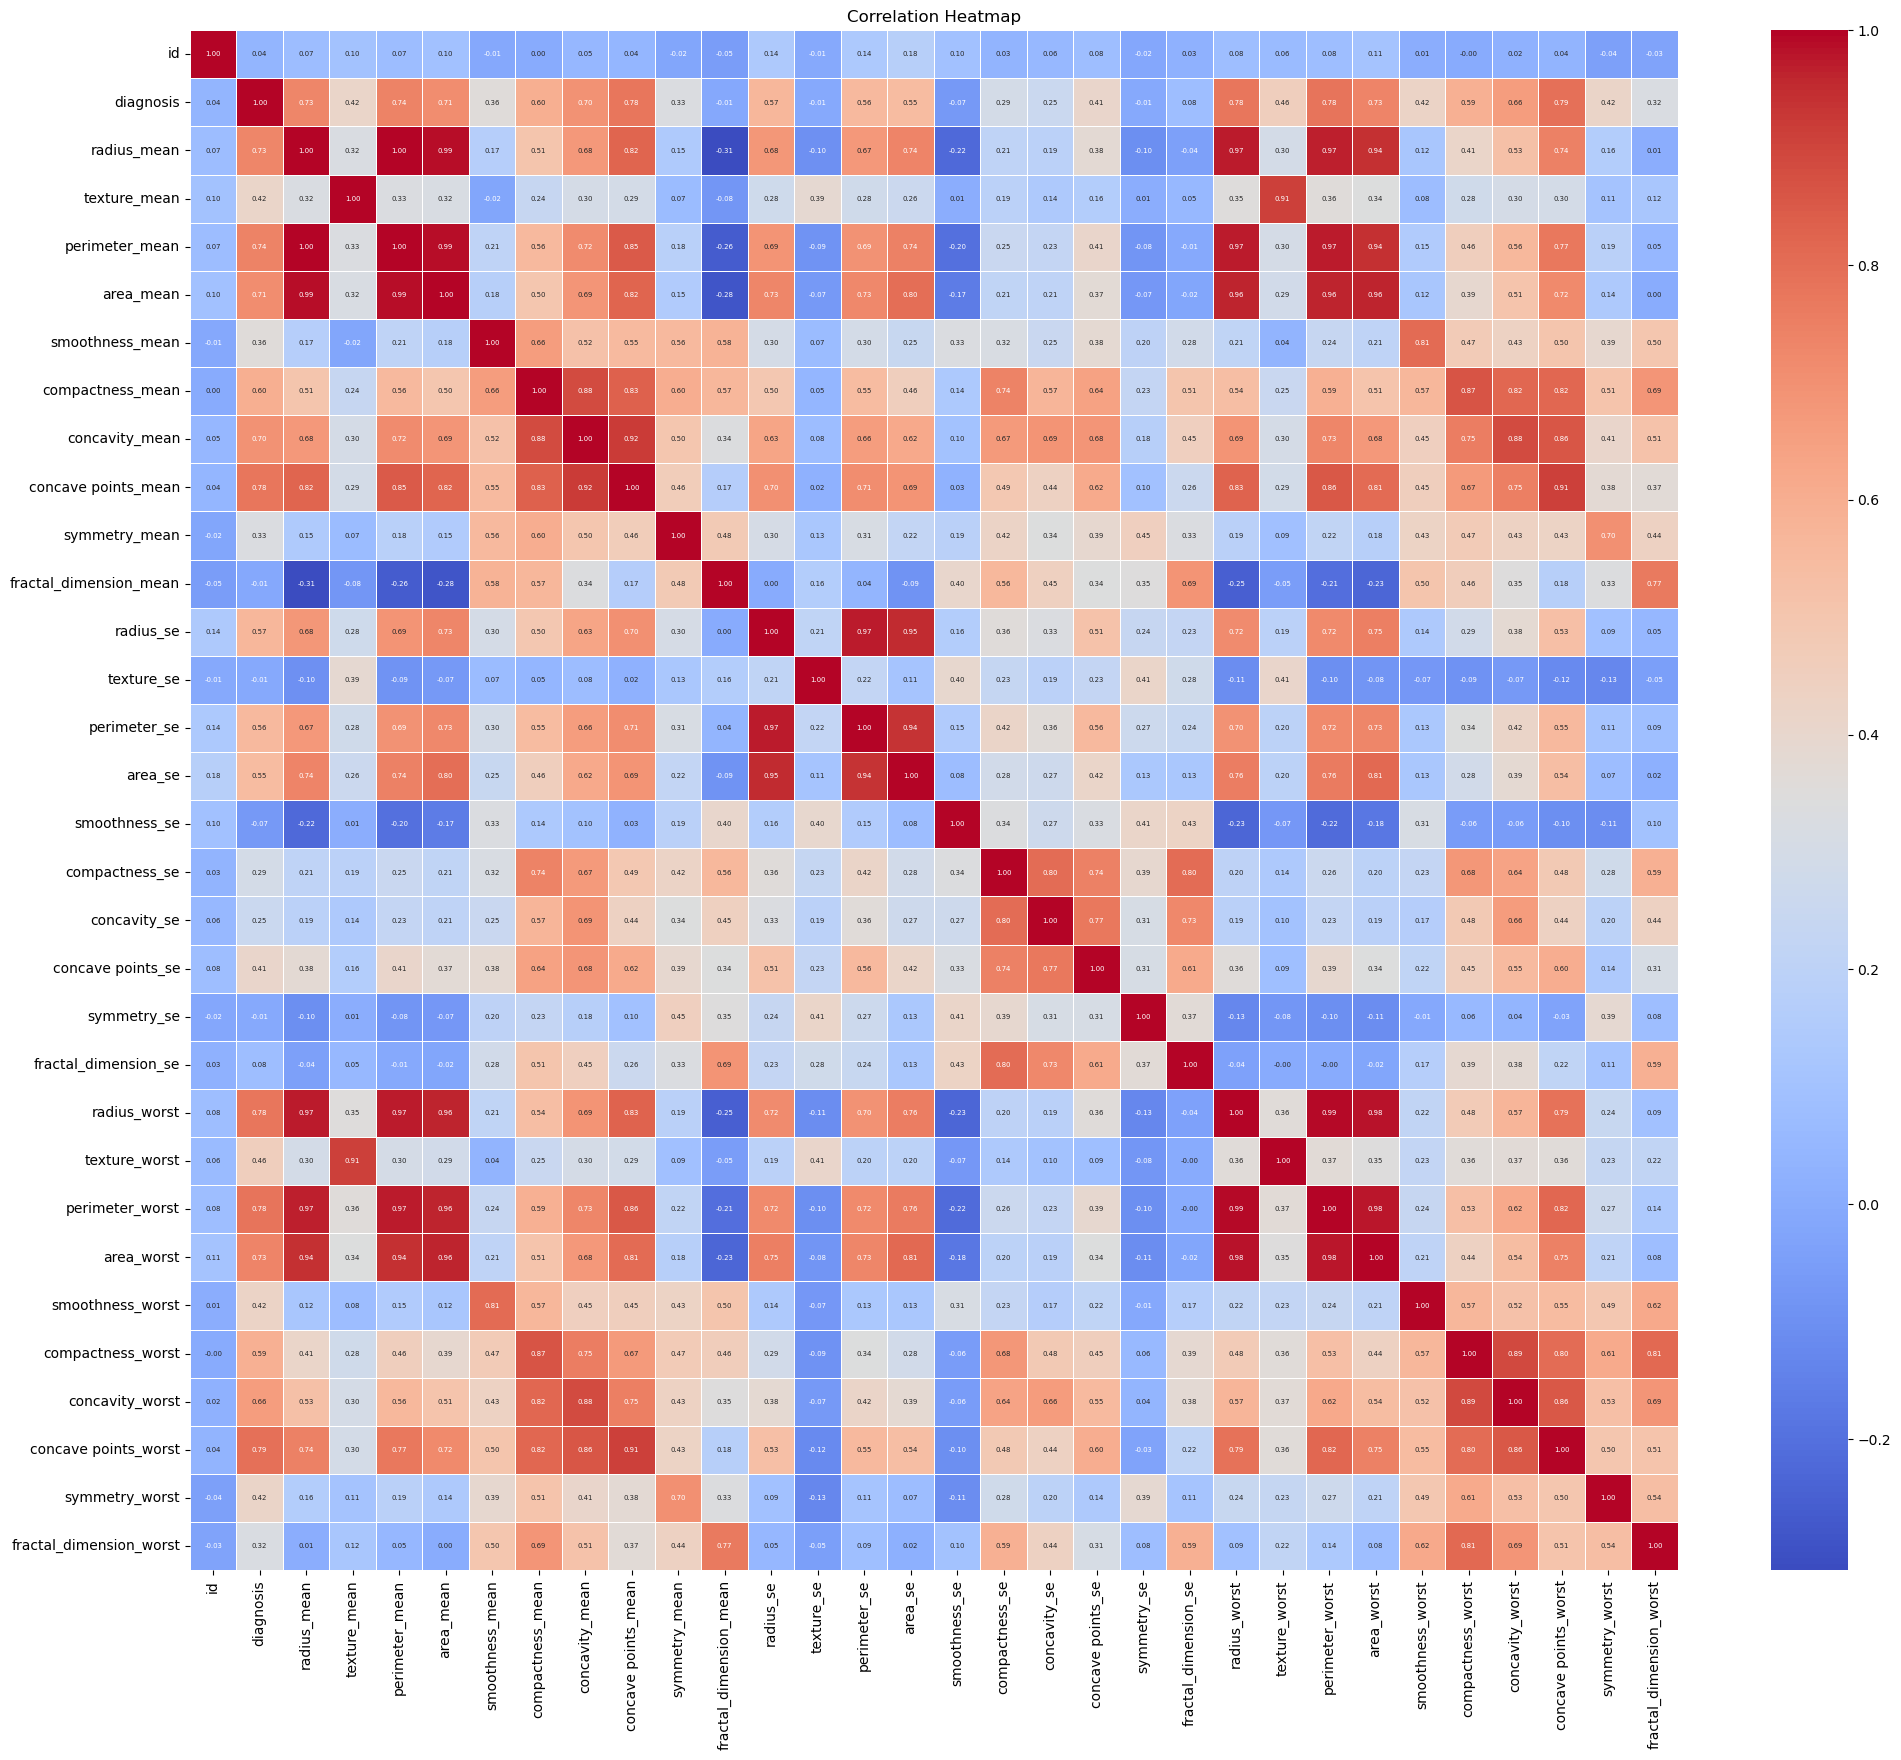

k  LR with Chi2 Accuracy  RF with Chi2 Accuracy  KNN with Chi2 Accuracy  \
0   3                 0.9227                 0.9086                  0.9192   
1   5                 0.9420                 0.9438                  0.9385   
2  10                 0.9350                 0.9438                  0.9367   

   LR with Forward Selection Accuracy  RF with Forward Selection Accuracy  \
0                              0.9561                              0.9614   
1                              0.9596                              0.9596   
2                              0.9684                              0.9666   

   KNN with Forward Selection Accuracy  LR with Backward Selection Accuracy  \
0                               0.9719                               0.9561   
1                               0.9649                               0.9596   
2                               0.9631                               0.9666   

   RF with Backward Selection Accuracy  KNN with Backward Selection Accuracy  \
0                               0.9614                                0.9719   
1                               0.9526                                0.9596   
2                               0.9649                                0.9684   

   LR with PCA Accuracy  RF with PCA Accuracy  KNN with PCA Accuracy  
0                0.9508                0.9491                 0.9438  
1                0.9666                0.9614                 0.9561  
2                0.9666                0.9543                 0.9701

In [43]:
c_cancer
# Checking for Null Values
null_check(c_cancer)
# No Null Values present hence Encoding Categorical Data to Numerical
c_cancer = transform_data(c_cancer)
# Detailed summary of Data types in DataFrame
print(c_cancer.info())
# Plotting the heatmap
plot_Heatmap(c_cancer)
c_cancer_results = fwpMethodsClassification(c_cancer, 'diagnosis')
display(c_cancer_results)

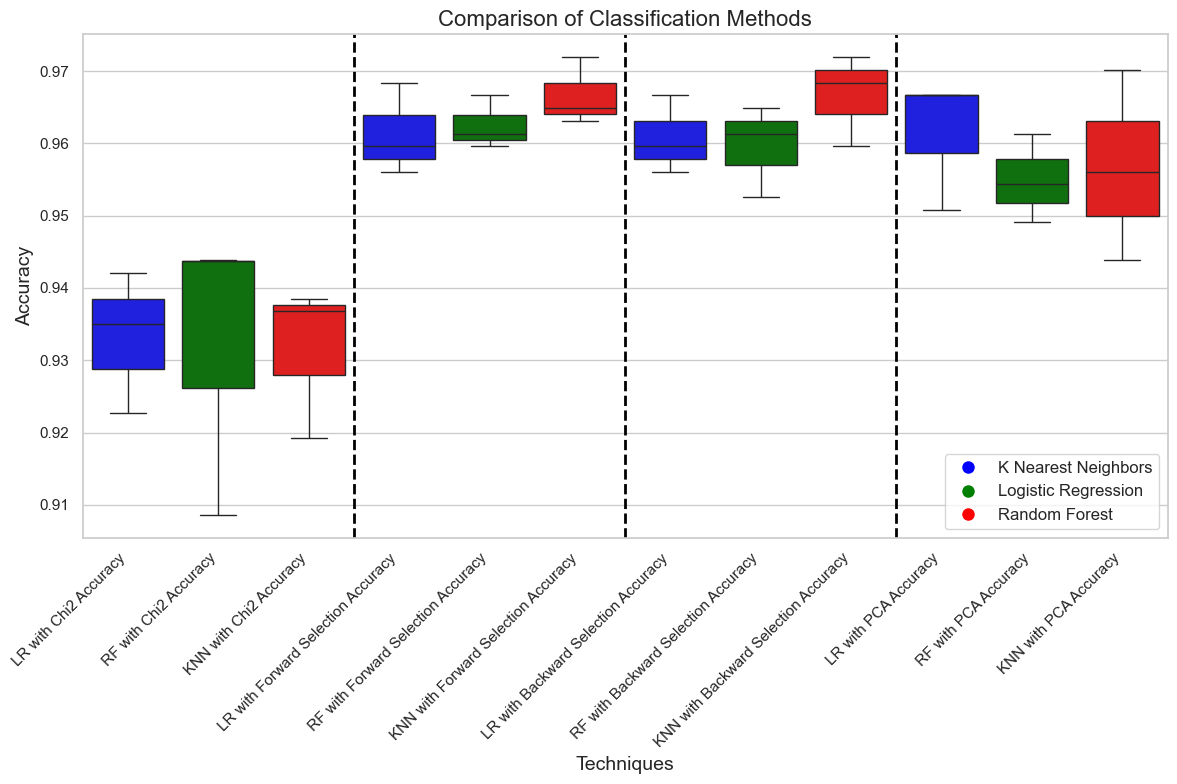

In [86]:
plot_results_boxplot(c_cancer_results)

### Interpretation:



## Dataset 2 : Mice Protein Expression Dataset (Classification)

Column Name: MouseID
Column DataType: int32
Column unique values: [ 45  52  53  54  55  56  57  58  59  46  47  48  49  50  51 282 289 290
 291 292 293 294 295 296 283 284 285 286 287 288 357 364 365 366 367 368
 369 370 371 358 359 360 361 362 363  15  22  23  24  25  26  27  28  29
  16  17  18  19  20  21  30  37  38  39  40  41  42  43  44  31  32  33
  34  35  36 297 304 305 306 307 308 309 310 311 298 299 300 301 302 303
 447 454 455 456 457 458 459 460 461 448 449 450 451 452 453 162 169 170
 171 172 173 174 175 176 163 164 165 166 167 168 177 184 185 186 187 188
 189 190 191 178 179 180 181 182 183 267 274 275 276 277 278 279 280 281
 268 269 270 271 272 273 477 484 485 486 487 488 489 490 491 478 479 480
 481 482 483 522 529 530 531 532 533 534 535 536 523 524 525 526 527 528
  75  82  83  84  85  86  87  88  89  76  77  78  79  80  81  90  97  98
  99 100 101 102 103 104  91  92  93  94  95  96 207 214 215 216 217 218
 219 220 221 208 209 210 211 212 213 222 229 230 231 232 2

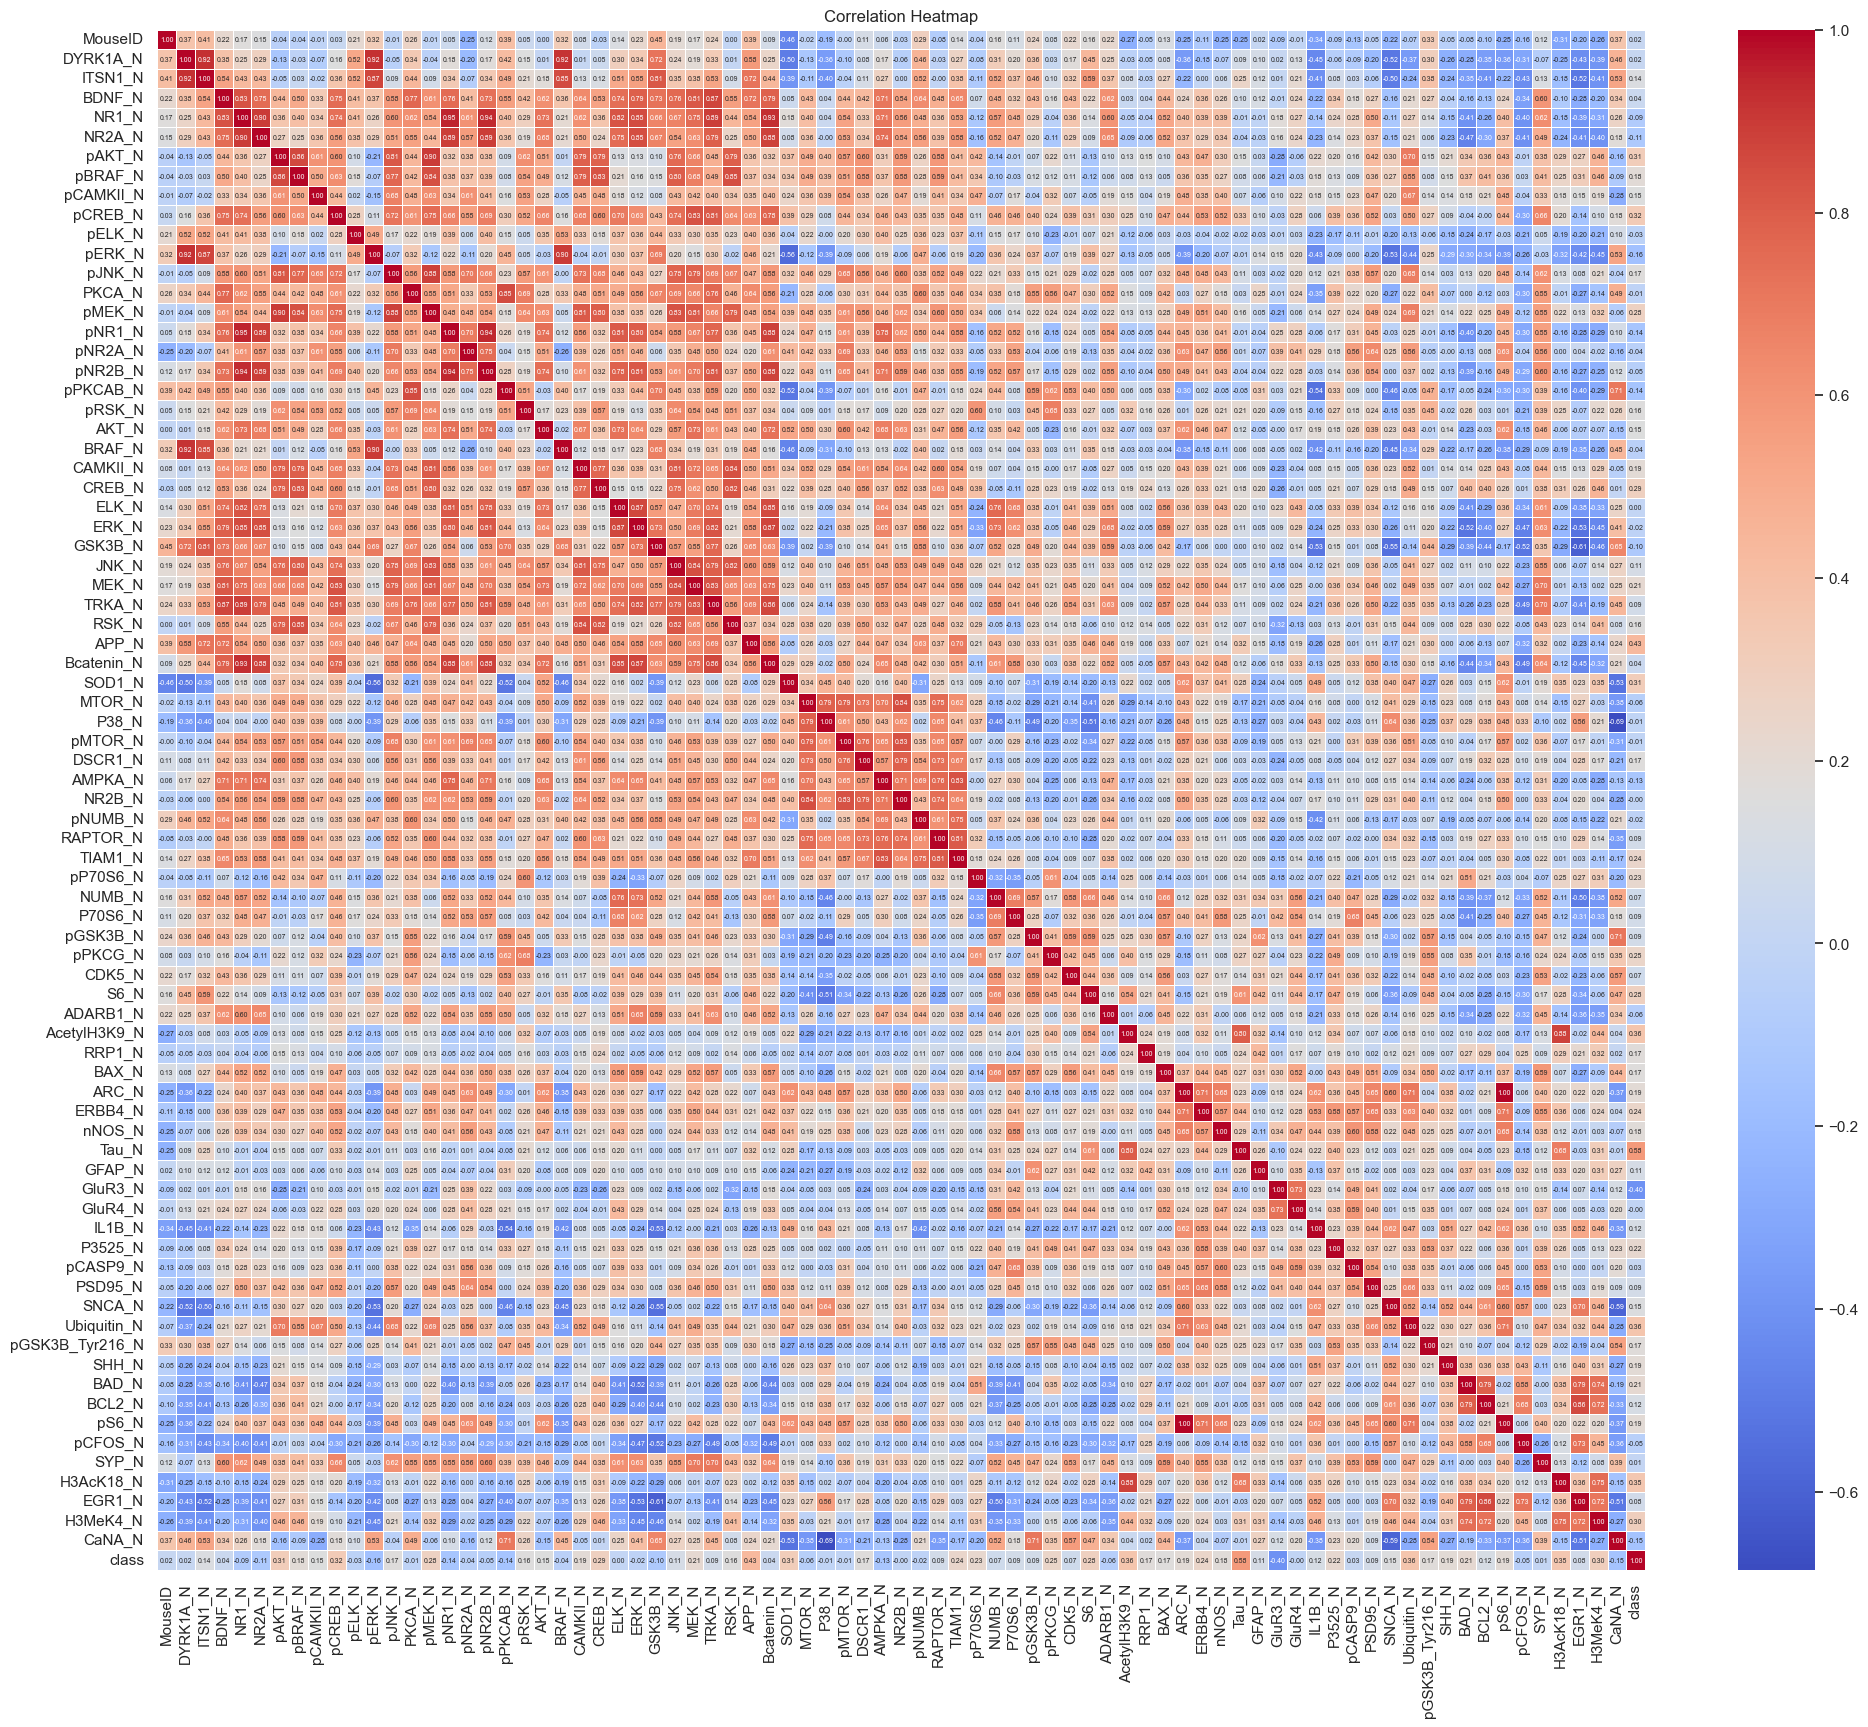

k  LR with Chi2 Accuracy  RF with Chi2 Accuracy  KNN with Chi2 Accuracy  \
0   3                 0.5452                 0.7028                  0.6431   
1   5                 0.6123                 0.8442                  0.8097   
2  10                 0.7554                 0.9620                  0.9637   

   LR with Forward Selection Accuracy  RF with Forward Selection Accuracy  \
0                              0.6322                              0.8261   
1                              0.7517                              0.9276   
2                              0.8332                              0.9620   

   KNN with Forward Selection Accuracy  LR with Backward Selection Accuracy  \
0                               0.7988                               0.5291   
1                               0.9003                               0.7101   
2                               0.9493                               0.8660   

   RF with Backward Selection Accuracy  KNN with Backward Selection Accuracy  \
0                               0.6993                                0.6739   
1                               0.8622                                0.9022   
2                               0.9728                                0.9765   

   LR with PCA Accuracy  RF with PCA Accuracy  KNN with PCA Accuracy  
0                0.4927                0.7372                 0.6230  
1                0.6068                0.9203                 0.8641  
2                0.9003                0.9873                 0.9637

In [96]:
c_mice_expression
# Checking for Null Values
null_check(c_mice_expression)
# Null Values present hence Removing the data
clean_data(c_mice_expression,[])
# No Null Values present hence Encoding Categorical Data to Numerical
c_mice_expression = transform_data(c_mice_expression)
# Detailed summary of Data types in DataFrame
print(c_mice_expression.info())
# Plotting the heatmap
plot_Heatmap(c_mice_expression)
c_mice_expression_results = fwpMethodsClassification(c_mice_expression, 'class')
display(c_mice_expression_results)

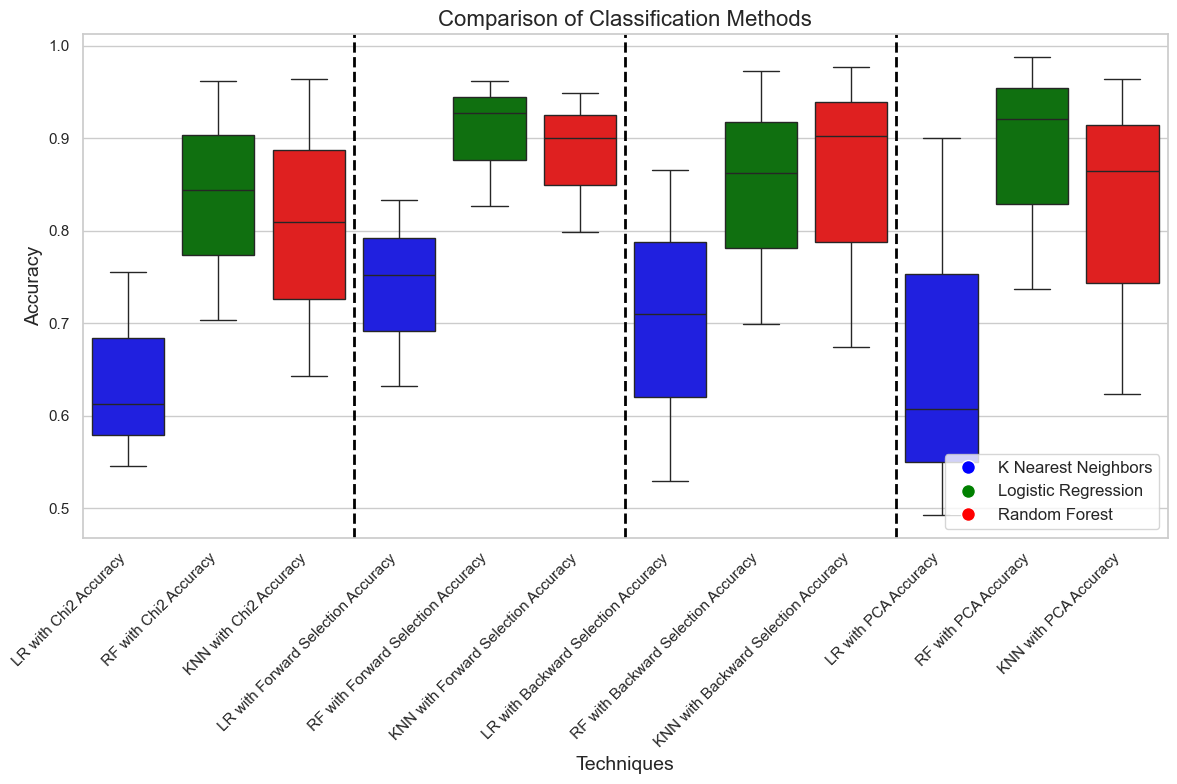

In [97]:
plot_results_boxplot(c_mice_expression_results)

### Interpretation:



## Dataset 3 : Adult Income Dataset (Classification)

Column Name: age
Column DataType: float64
Column has null: False


Column Name: workclass
Column DataType: int32
Column unique values: [5 4 2 0 1 3 6]
Column has null: False


Column Name: fnlwgt
Column DataType: float64
Column has null: False


Column Name: education
Column DataType: int32
Column unique values: [ 9 11  1 12  6 15  7  5 10  8 14  4  0 13  2  3]
Column has null: False


Column Name: education-num
Column DataType: float64
Column has null: False


Column Name: marital-status
Column DataType: int32
Column unique values: [4 2 0 3 5 1 6]
Column has null: False


Column Name: occupation
Column DataType: int32
Column unique values: [ 0  3  5  9  7 11 13  4  6 12  2 10  1  8]
Column has null: False


Column Name: relationship
Column DataType: int32
Column unique values: [1 0 5 3 4 2]
Column has null: False


Column Name: race
Column DataType: int32
Column unique values: [4 2 1 0 3]
Column has null: False


Column Name: sex
Column DataType: int32
Column unique values: [1 0]
Colu

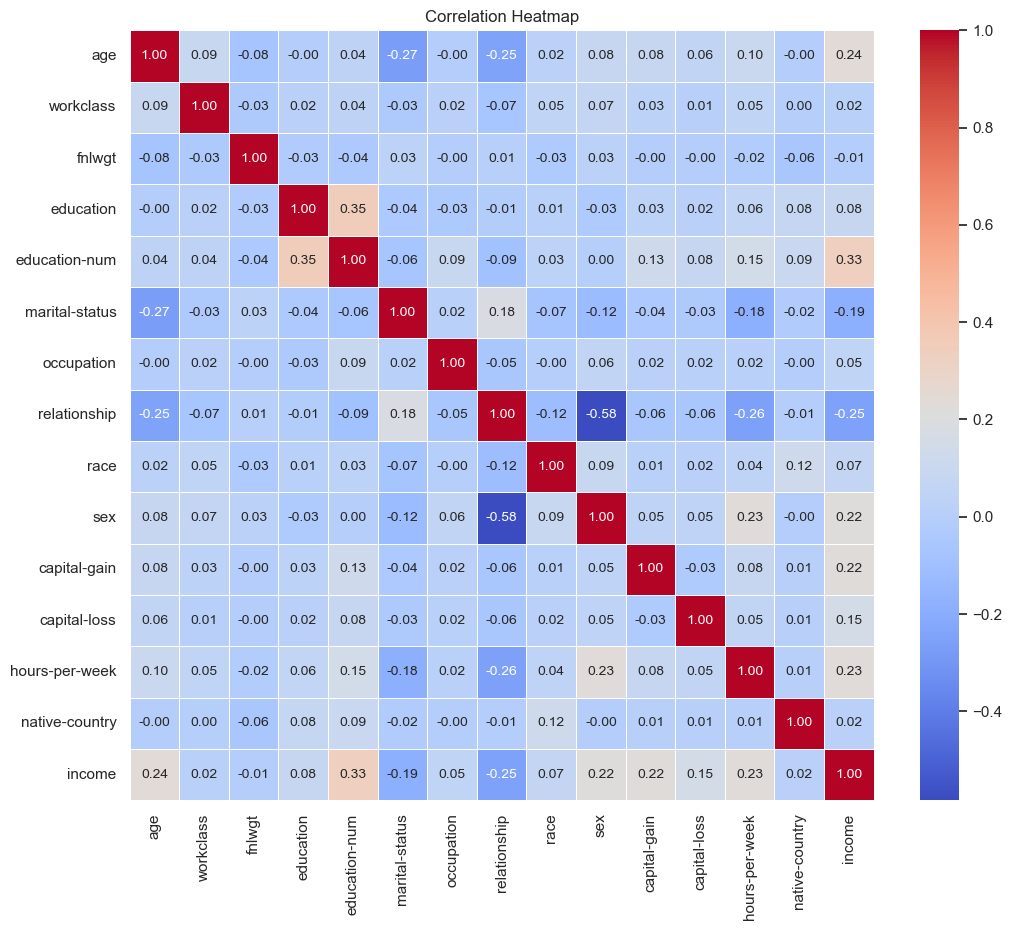

k  LR with Chi2 Accuracy  RF with Chi2 Accuracy  KNN with Chi2 Accuracy  \
0   3                 0.7896                 0.8036                  0.7546   
1   5                 0.7953                 0.8230                  0.7947   
2  10                 0.8182                 0.8418                  0.8225   

   LR with Forward Selection Accuracy  RF with Forward Selection Accuracy  \
0                              0.8055                              0.8254   
1                              0.8044                              0.7530   
2                              0.8000                              0.8274   

   KNN with Forward Selection Accuracy  LR with Backward Selection Accuracy  \
0                               0.8040                               0.8195   
1                               0.7778                               0.8264   
2                               0.8193                               0.8241   

   RF with Backward Selection Accuracy  KNN with Backward Selection Accuracy  \
0                               0.8454                                0.7951   
1                               0.8449                                0.8055   
2                               0.8266                                0.8219   

   LR with PCA Accuracy  RF with PCA Accuracy  KNN with PCA Accuracy  
0                0.7600                0.8095                 0.8090  
1                0.7583                0.8101                 0.8086  
2                0.8028                0.8187                 0.8137

In [98]:
c_adult_income
# Checking for Null Values
null_check(c_adult_income)
# Null Values present hence Removing the data
clean_data(c_adult_income,[])
# No Null Values present hence Encoding Categorical Data to Numerical
c_adult_income = transform_data(c_adult_income)
# Detailed summary of Data types in DataFrame
print(c_adult_income.info())
# Plotting the heatmap
plot_Heatmap(c_adult_income)
c_adult_income_results = fwpMethodsClassification(c_adult_income, 'income')
display(c_adult_income_results)

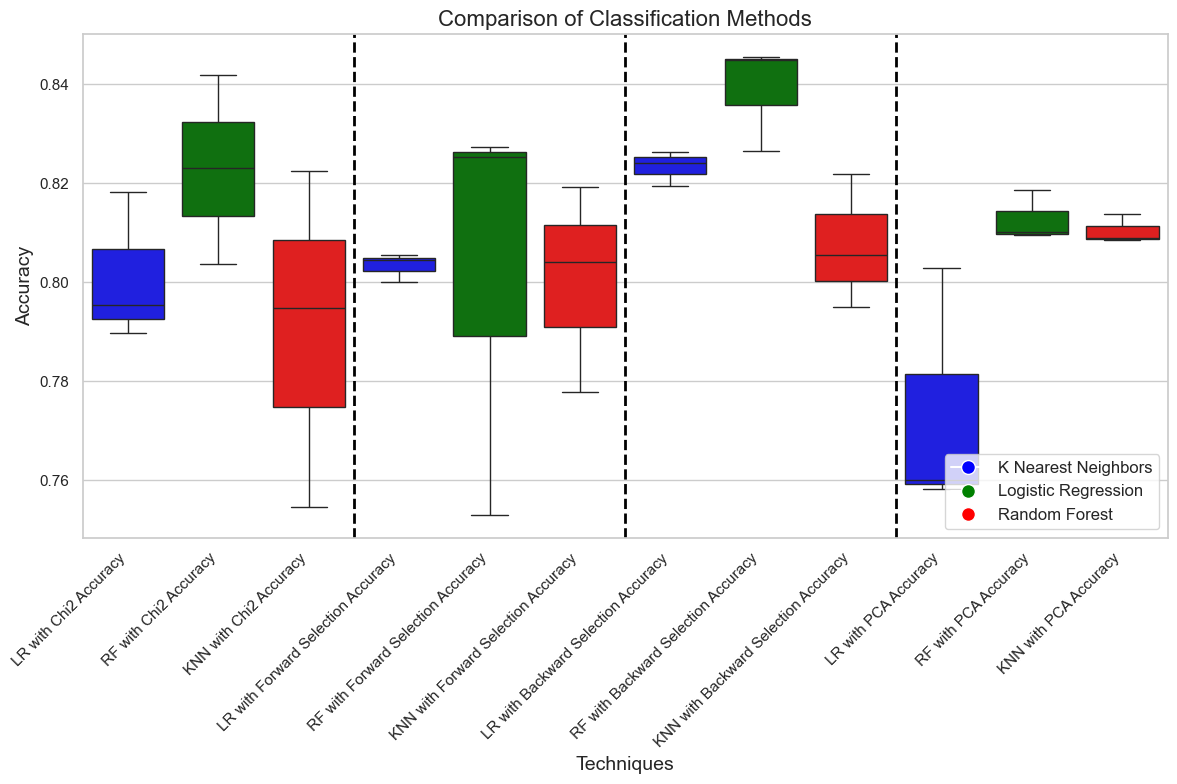

In [99]:
plot_results_boxplot(c_adult_income_results)

### Interpretation:



# Regression Datasets

## Dataset 4 : Life Expectancy Dataset (Regression)

Column Name: Country
Column DataType: int32
Column unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132]
Column has null: False


Column Name: Year
Column DataType: float64
Column has null: False


Column Name: Status
Column DataType: int32
Column unique values: [1 0]
Column has null: False


Column Name: Life expectancy 
Column DataType: float64
Column has null: False


Column Name: Adult Mortality
Column DataType: float64
Column has null: False


Column Name: infant deaths
Column DataType: f

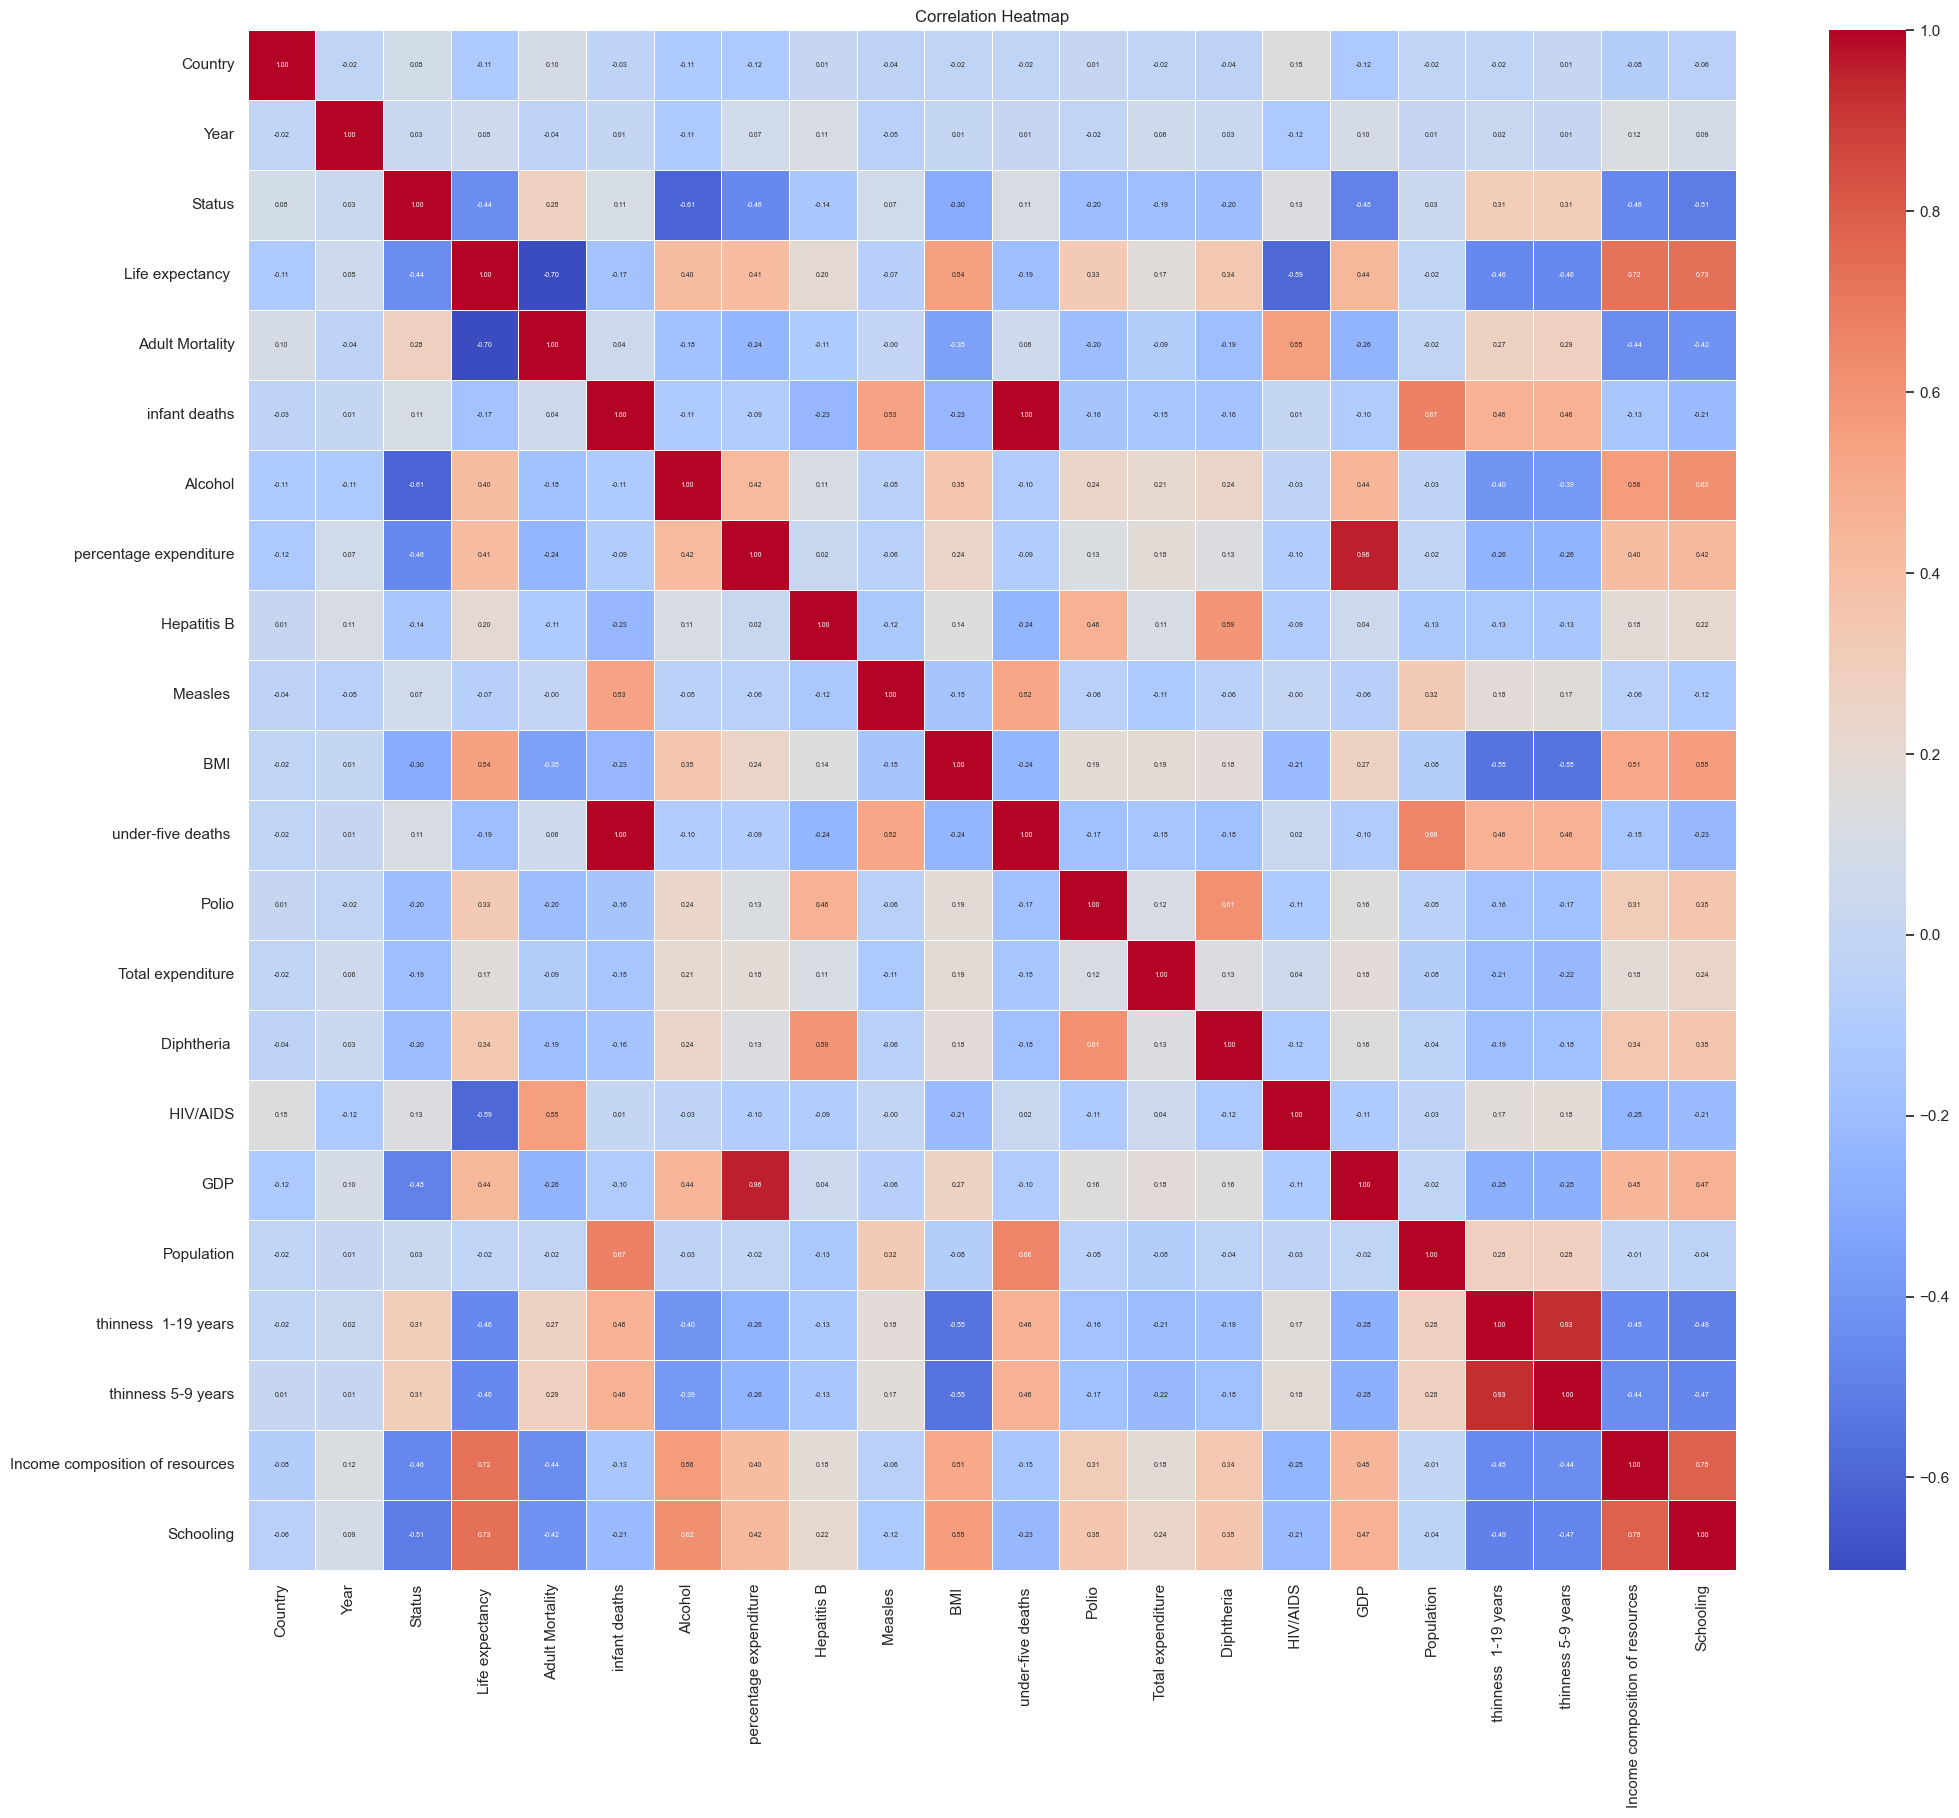

k  LR with Forward Selection MSE  RF with Forward Selection MSE  \
0   3                         0.2452                         0.0578   
1   5                         0.1902                         0.0485   
2  10                         0.1791                         0.0486   

   KNN with Forward Selection MSE  LR with Backward Selection MSE  \
0                          0.0653                          0.2147   
1                          0.0702                          0.1902   
2                          0.1060                          0.1692   

   RF with Backward Selection MSE  KNN with Backward Selection MSE  \
0                          0.0597                           0.0778   
1                          0.0488                           0.0702   
2                          0.0468                           0.1023   

   LR with PCA MSE  RF with PCA MSE  KNN with PCA MSE  LR with ANOVA MSE  \
0           0.4881           0.3518            0.3432             0.2617   
1           0.4189           0.2918            0.2923             0.1902   
2           0.2077           0.1402            0.1565             0.1855   

   RF with ANOVA MSE  KNN with ANOVA MSE  LR with ANOVA MAE  \
0             0.0646              0.0785             0.3597   
1             0.0489              0.0702             0.3305   
2             0.0456              0.0763             0.3277   

   RF with ANOVA MAE  KNN with ANOVA MAE  LR with ANOVA R-squared  \
0             0.1600              0.1841                   0.7363   
1             0.1390              0.1770                   0.8075   
2             0.1335              0.1808                   0.8124   

   RF with ANOVA R-squared  KNN with ANOVA R-squared  
0                   0.9354                    0.9215  
1                   0.9510                    0.9290  
2                   0.9539                    0.9229

In [125]:
r_life_expectancy
# Checking for Null Values
null_check(r_life_expectancy)
# Null Values present hence Removing the data
clean_data(r_life_expectancy,[])
# Encoding Categorical Data to Numerical
r_life_expectancy = transform_data(r_life_expectancy)
print(r_life_expectancy.info())
# Plotting the heatmap
plot_Heatmap(r_life_expectancy)
r_life_expectancy_results = fwpMethodsRegression(r_life_expectancy, 'Life expectancy ')
display(r_life_expectancy_results)

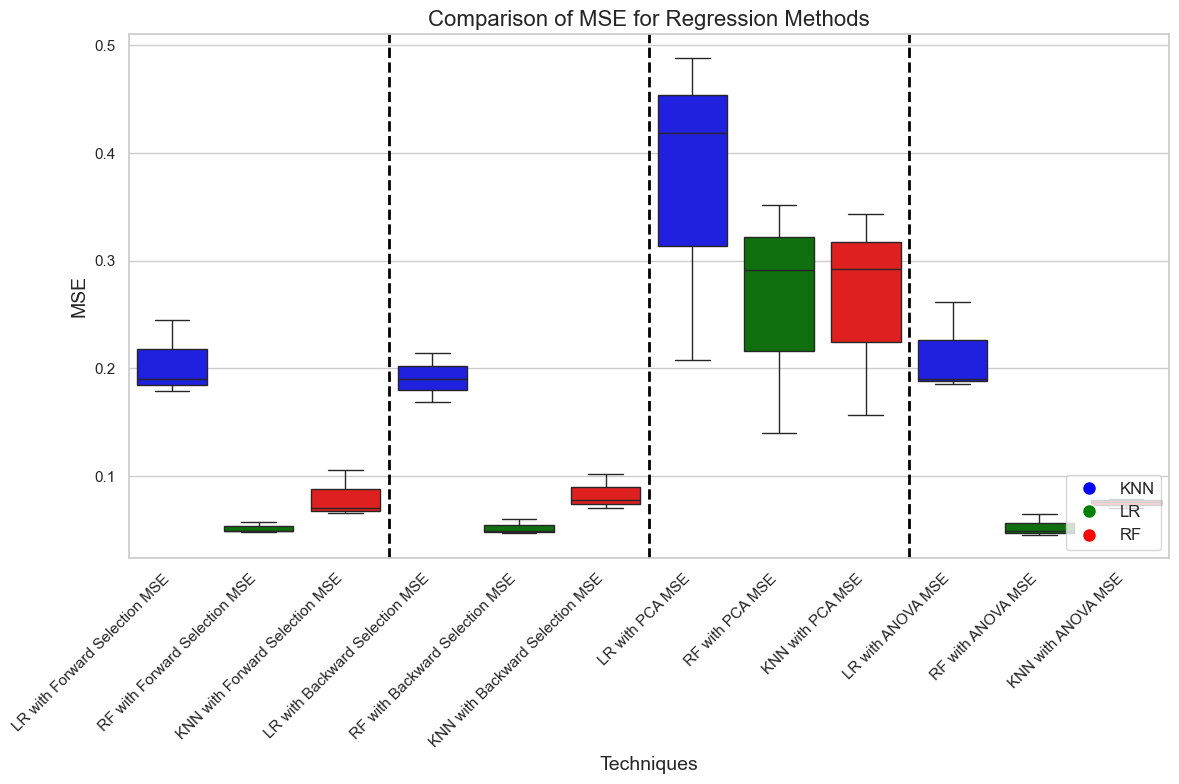

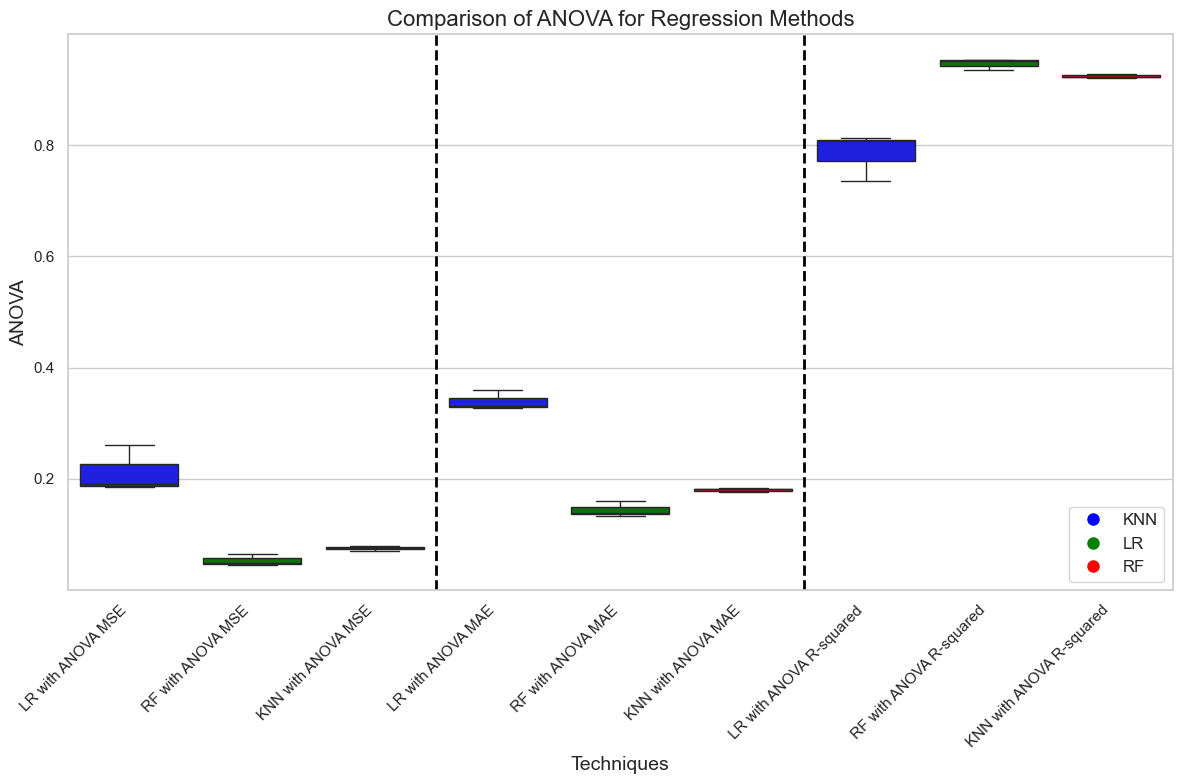

In [126]:
plot_results_boxplot_r(r_life_expectancy_results)

### Interpretation:



## Dataset 5 : Appartment Rent Estimation (Regression)

Column Name: id
Column DataType: int64
Column has null: False


Column Name: category
Column DataType: object
Column unique values: ['housing/rent/apartment' 'housing/rent/home' 'housing/rent/short_term']
Column has null: False


Column Name: amenities
Column DataType: object
Column unique values: ['Unknown' 'Fireplace,Gym,Parking,Pool,Storage,Wood Floors' 'Gated,Pool'
 ... 'AC,Cable or Satellite,Elevator,Internet Access,Wood Floors'
 'Elevator,Washer Dryer'
 'AC,Cable or Satellite,Parking,Pool,Washer Dryer,Wood Floors']
Column has null: False


Column Name: bathrooms
Column DataType: float64
Column has null: False


Column Name: bedrooms
Column DataType: int64
Column has null: False


Column Name: currency
Column DataType: object
Column unique values: ['USD']
Column has null: False


Column Name: fee
Column DataType: object
Column unique values: ['No']
Column has null: False


Column Name: has_photo
Column DataType: object
Column unique values: ['Thumbnail' 'No' 'Yes']
Column has null

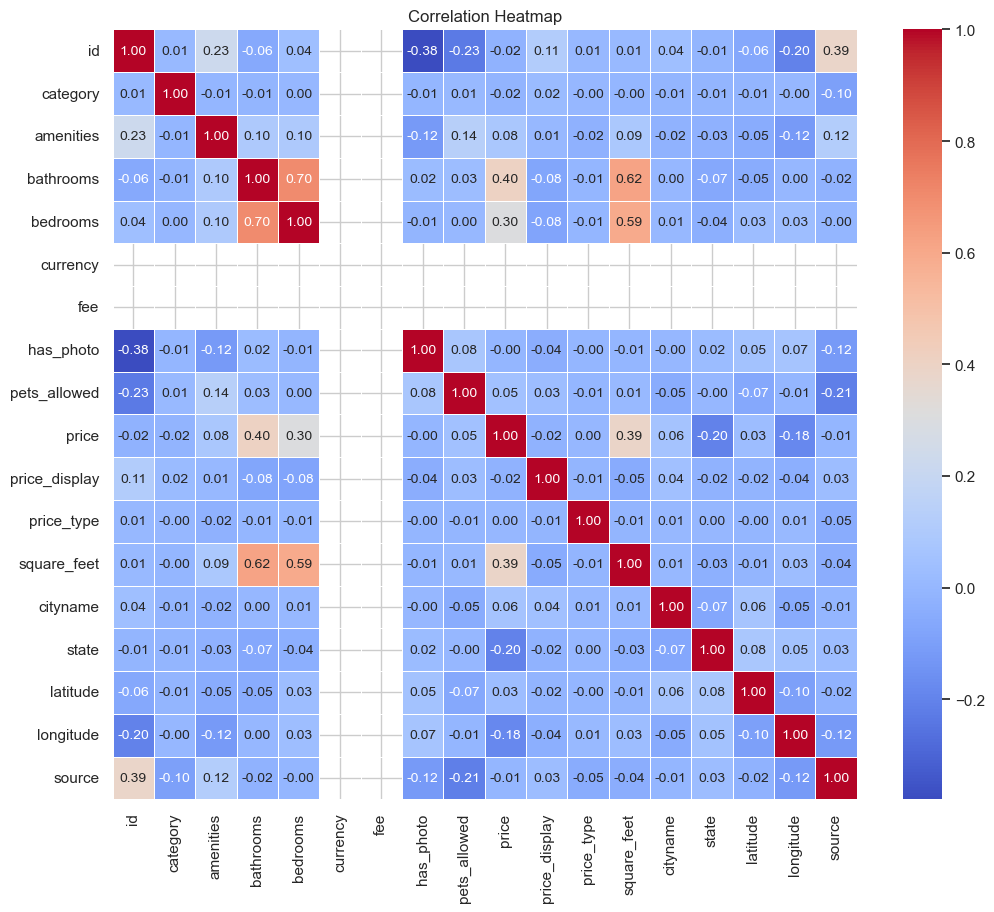

k  LR with Forward Selection MSE  RF with Forward Selection MSE  \
0   3                         0.7789                         0.5728   
1   5                         0.7927                         0.4805   
2  10                         0.7909                         0.4812   

   KNN with Forward Selection MSE  LR with Backward Selection MSE  \
0                          0.5606                          0.7789   
1                          0.5307                          0.7927   
2                          0.6103                          0.7909   

   RF with Backward Selection MSE  KNN with Backward Selection MSE  \
0                          0.5884                           0.5606   
1                          0.4795                           0.5307   
2                          0.4906                           0.6103   

   LR with PCA MSE  RF with PCA MSE  KNN with PCA MSE  LR with ANOVA MSE  \
0           0.9953           0.7576            0.8224             0.8768   
1           0.9453           0.6416            0.6187             0.8149   
2           0.8002           0.5271            0.4660             0.8129   

   RF with ANOVA MSE  KNN with ANOVA MSE  LR with ANOVA MAE  \
0             0.9265              0.8558             0.4957   
1             0.4898              0.5431             0.4754   
2             0.3491              0.4384             0.4694   

   RF with ANOVA MAE  KNN with ANOVA MAE  LR with ANOVA R-squared  \
0             0.5178              0.5147                   0.1148   
1             0.2667              0.3023                   0.1836   
2             0.0368              0.1367                   0.1859   

   RF with ANOVA R-squared  KNN with ANOVA R-squared  
0                   0.0525                    0.1495  
1                   0.5861                    0.5200  
2                   0.7409                    0.6643

In [127]:
r_appartment_rent
# Checking for Null Values
null_check(r_appartment_rent)
# No Null Values present hence Encoding Categorical Data to Numerical
r_appartment_rent = transform_data(r_appartment_rent)
print(r_appartment_rent.info())
# Plotting the heatmap
plot_Heatmap(r_appartment_rent)
r_appartment_rent_results = fwpMethodsRegression(r_appartment_rent, 'price')
display(r_appartment_rent_results)

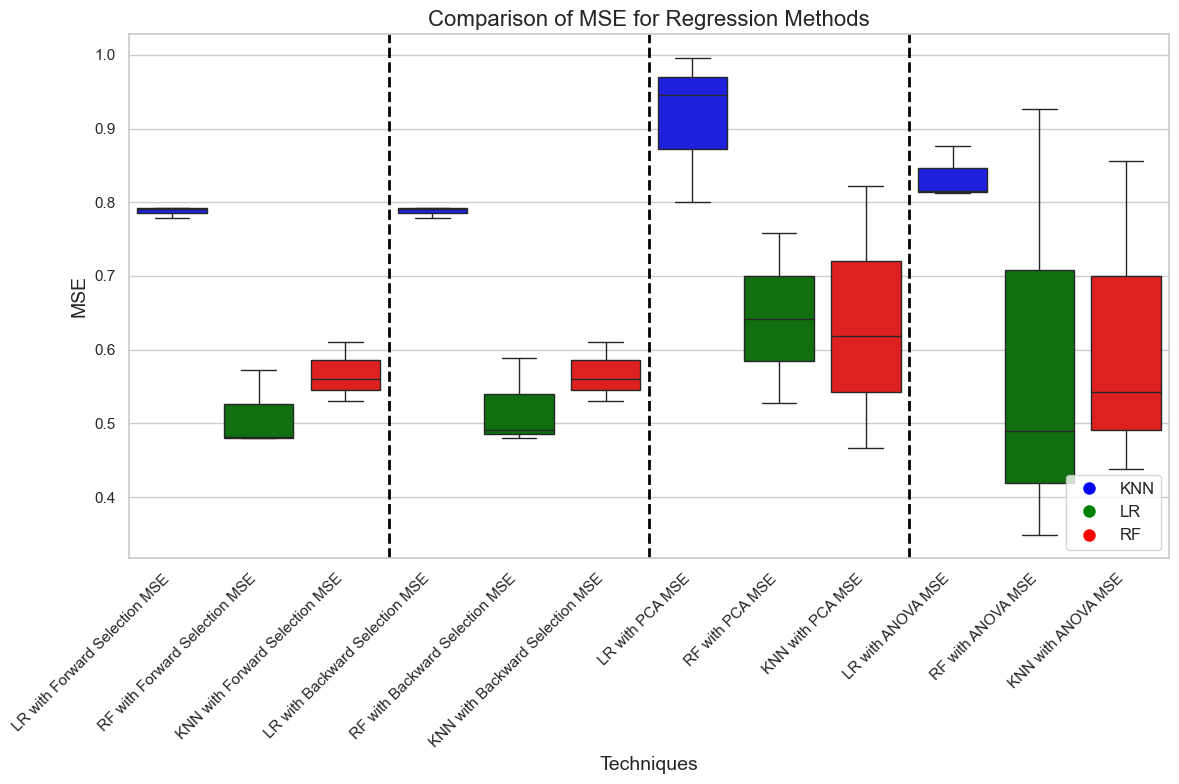

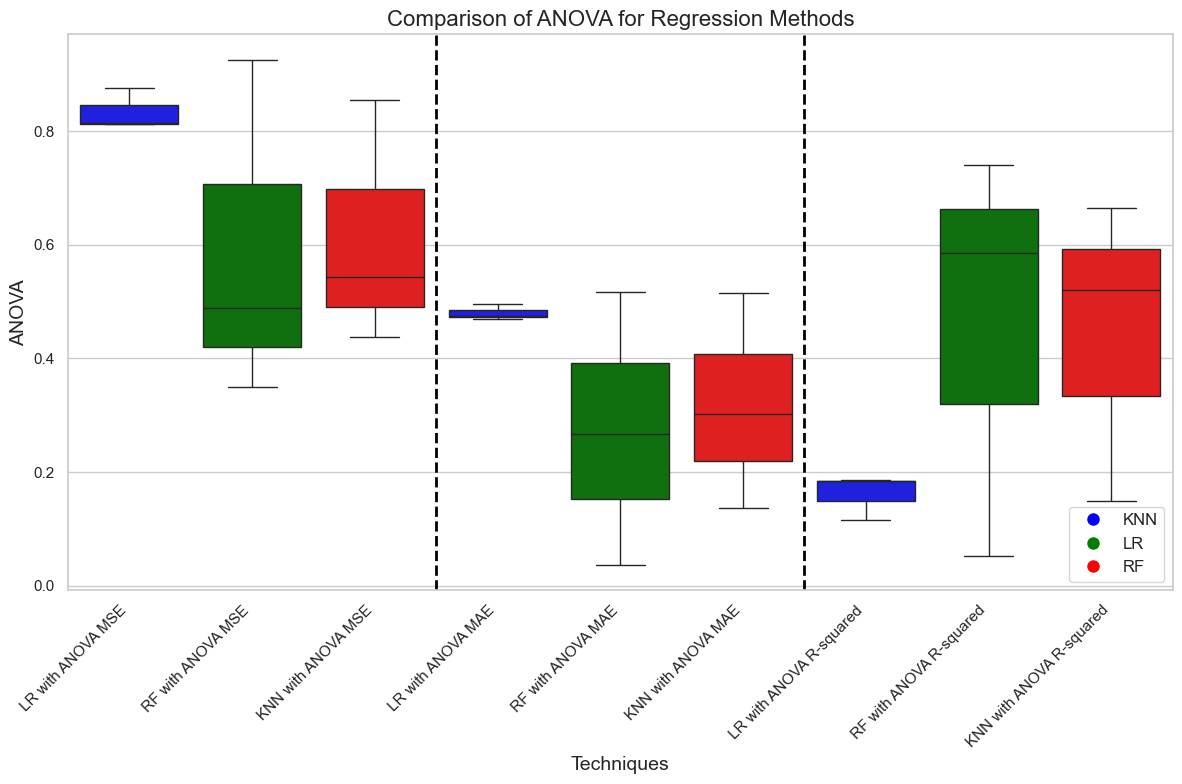

In [128]:
plot_results_boxplot_r(r_appartment_rent_results)

### Interpretation:


## Dataset 6 : Song Popularity Estimation (Regression)

Column Name: song_name
Column DataType: int32
Column unique values: [ 791 2825 4886 ... 2652 1447 1771]
Column has null: False


Column Name: song_popularity
Column DataType: float64
Column has null: False


Column Name: song_duration_ms
Column DataType: float64
Column has null: False


Column Name: acousticness
Column DataType: float64
Column has null: False


Column Name: danceability
Column DataType: float64
Column has null: False


Column Name: energy
Column DataType: float64
Column has null: False


Column Name: instrumentalness
Column DataType: float64
Column has null: False


Column Name: key
Column DataType: float64
Column has null: False


Column Name: liveness
Column DataType: float64
Column has null: False


Column Name: loudness
Column DataType: float64
Column has null: False


Column Name: audio_mode
Column DataType: float64
Column has null: False


Column Name: speechiness
Column DataType: float64
Column has null: False


Column Name: tempo
Column DataType: float64
Column

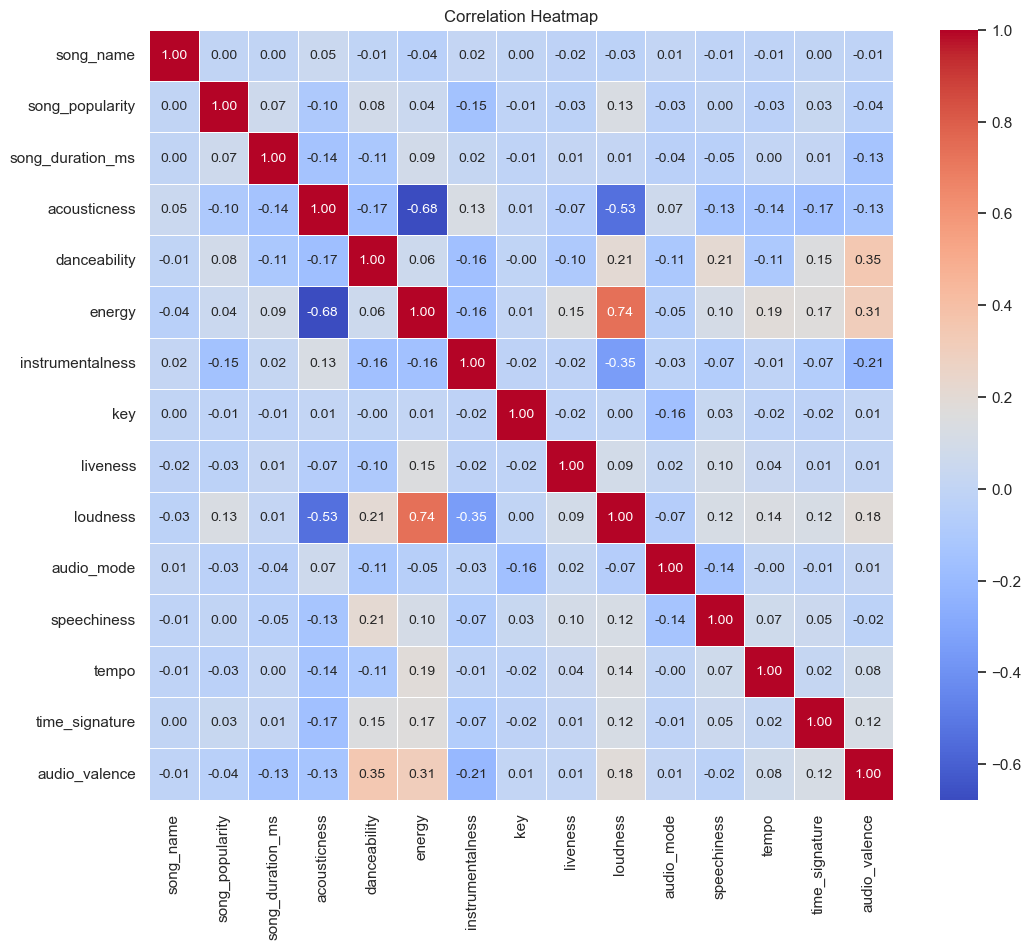

k  LR with Forward Selection MSE  RF with Forward Selection MSE  \
0   3                         0.9785                         0.8411   
1   5                         0.9740                         0.8097   
2  10                         0.9687                         0.7779   

   KNN with Forward Selection MSE  LR with Backward Selection MSE  \
0                          1.0625                          0.9723   
1                          1.0834                          0.9669   
2                          1.0557                          0.9664   

   RF with Backward Selection MSE  KNN with Backward Selection MSE  \
0                          0.8478                           1.0566   
1                          0.7737                           1.0206   
2                          0.7683                           1.0440   

   LR with PCA MSE  RF with PCA MSE  KNN with PCA MSE  LR with ANOVA MSE  \
0           0.9919           0.8482            1.0628             0.9706   
1           0.9918           0.8016            1.0555             0.9647   
2           0.9570           0.7564            1.0226             0.9515   

   RF with ANOVA MSE  KNN with ANOVA MSE  LR with ANOVA MAE  \
0             0.8317              1.0579             0.7880   
1             0.7734              1.0152             0.7846   
2             0.7359              1.0163             0.7795   

   RF with ANOVA MAE  KNN with ANOVA MAE  LR with ANOVA R-squared  \
0             0.6957              0.8124                   0.0286   
1             0.6635              0.7924                   0.0345   
2             0.6461              0.7908                   0.0478   

   RF with ANOVA R-squared  KNN with ANOVA R-squared  
0                   0.1654                   -0.0590  
1                   0.2296                   -0.0158  
2                   0.2608                   -0.0168

In [93]:
r_song_popularity
# Checking for Null Values
null_check(r_song_popularity)
# No Null Values present hence Encoding Categorical Data to Numerical
r_song_popularity = transform_data(r_song_popularity)
print(r_song_popularity.info())
# Plotting the heatmap
plot_Heatmap(r_song_popularity)
r_song_popularity_results = fwpMethodsRegression(r_song_popularity, 'song_popularity')
display(r_song_popularity_results)

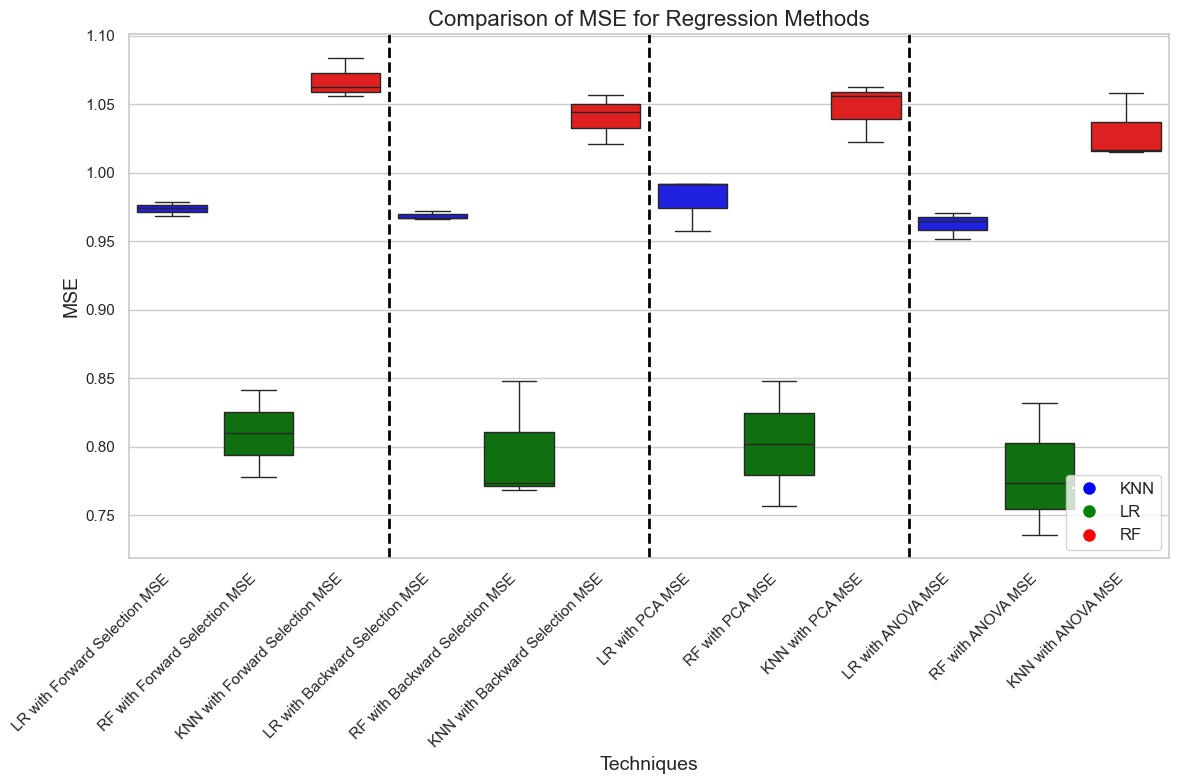

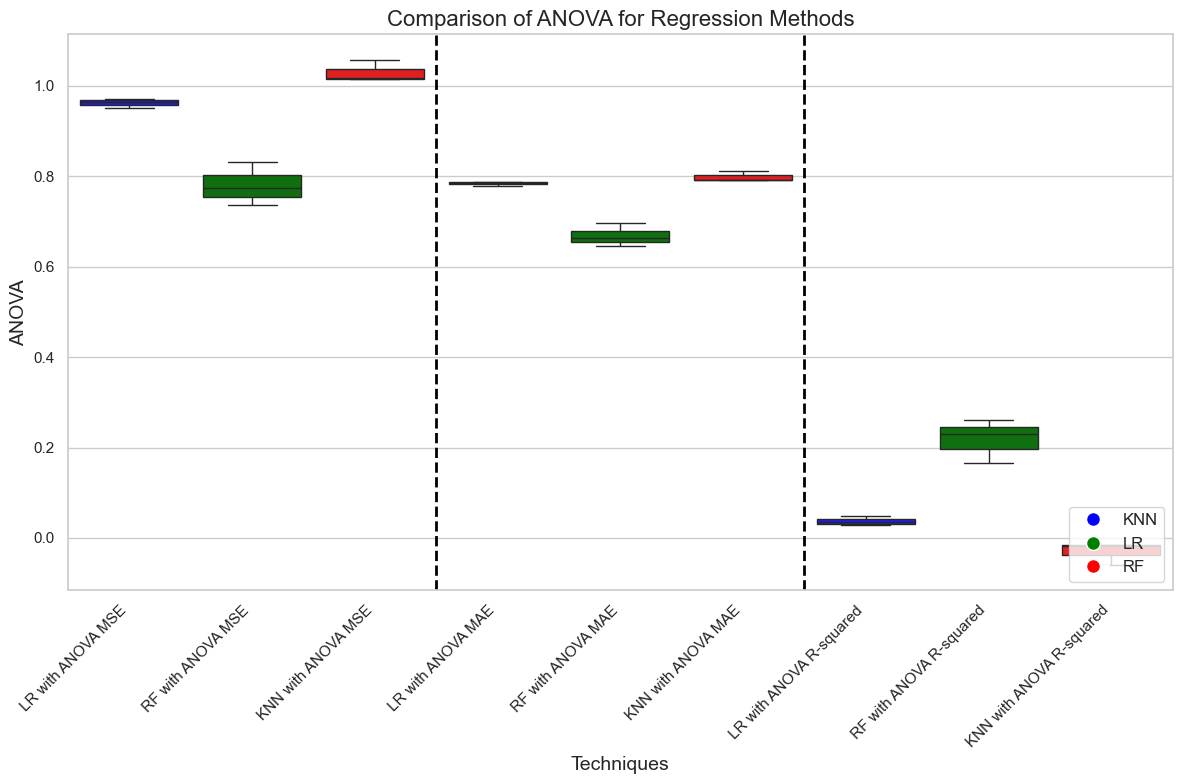

In [123]:
plot_results_boxplot_r(r_song_popularity_results)

### Interpretation:
